## Import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

## Hyperparameter setting

In [ ]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

## Data Load

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [ ]:
print(train.shape)
print(test.shape)

(14095, 54)
(6041, 19)


## Data Preprocessing
#### 1. 결측치 처리
#### 2. Train / Validation 분할
#### 3. Data label-encoding, scaling

In [ ]:
train.head(10)

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0
5,TRAIN_00005,COMPONENT3,2061,2008,4,550,0,3,8,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,69.7,1015,0
6,TRAIN_00006,COMPONENT3,1416,2015,7,616,0,0,21,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,148.5,24,0
7,TRAIN_00007,COMPONENT3,1170,2009,4,370,0,5,3,3,...,NaN,NaN,NaN,NaN,NaN,0,NaN,142.9,16,0
8,TRAIN_00008,COMPONENT3,4880,2014,7,200,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,140.7,89,0
9,TRAIN_00009,COMPONENT1,6748,2015,6,200,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,0,13.4,98.9,1020,0


In [ ]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [ ]:
# 결측치 처리
train = train.fillna(0)
test = test.fillna(0)

In [ ]:
all_X = train.drop(['ID', 'Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']

test = test.drop(['ID'], axis = 1)

train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [ ]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))

le = LabelEncoder()
for col in categorical_features:
    train_X[col] = le.fit_transform(train_X[col])
    val_X[col] = le.transform(val_X[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

## CustomDataset

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation

    def __len__(self):
        return len(self.data_X)

    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [ ]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

## Define Teacher Model

In [ ]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=52, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.classifier(x)
        return output

## Teacher Train / Validation

In [ ]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35

    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)

            model_pred = model(X.to(device))

            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())

            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()

        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []

        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)

            optimizer.zero_grad()

            y_pred = model(X)

            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()

            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)

        if best_score < val_score:
            best_model = model
            best_score = val_score

    return best_model

## Run (Teacher Model)

In [ ]:
model = Teacher()
model.eval()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.25331] Val Loss : [0.37714] Val F1 Score : [0.65845]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.20144] Val Loss : [0.25767] Val F1 Score : [0.78043]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.17957] Val Loss : [0.28856] Val F1 Score : [0.78962]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.17851] Val Loss : [0.25898] Val F1 Score : [0.76305]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.18265] Val Loss : [0.23416] Val F1 Score : [0.78432]
Epoch 00005: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.17114] Val Loss : [0.23996] Val F1 Score : [0.78612]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.15563] Val Loss : [0.27076] Val F1 Score : [0.79052]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.15011] Val Loss : [0.27420] Val F1 Score : [0.79705]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.14826] Val Loss : [0.26354] Val F1 Score : [0.79419]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.14717] Val Loss : [0.29247] Val F1 Score : [0.79823]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.14720] Val Loss : [0.28909] Val F1 Score : [0.77611]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.14676] Val Loss : [0.28560] Val F1 Score : [0.80248]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.15212] Val Loss : [0.31796] Val F1 Score : [0.79438]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.14463] Val Loss : [0.24060] Val F1 Score : [0.80251]
Epoch 00014: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.13970] Val Loss : [0.27687] Val F1 Score : [0.79520]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.13211] Val Loss : [0.26134] Val F1 Score : [0.79126]
Epoch 00016: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.13422] Val Loss : [0.28820] Val F1 Score : [0.80279]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.12435] Val Loss : [0.27667] Val F1 Score : [0.79535]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.12086] Val Loss : [0.28087] Val F1 Score : [0.80197]
Epoch 00019: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.11740] Val Loss : [0.29820] Val F1 Score : [0.77272]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.11496] Val Loss : [0.26900] Val F1 Score : [0.79862]
Epoch 00021: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.12523] Val Loss : [0.29223] Val F1 Score : [0.77048]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.11272] Val Loss : [0.29414] Val F1 Score : [0.79794]
Epoch 00023: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.11162] Val Loss : [0.29304] Val F1 Score : [0.80196]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.11137] Val Loss : [0.30658] Val F1 Score : [0.79556]
Epoch 00025: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.11222] Val Loss : [0.30271] Val F1 Score : [0.76910]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.11629] Val Loss : [0.29456] Val F1 Score : [0.80955]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.10824] Val Loss : [0.30714] Val F1 Score : [0.79552]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.11851] Val Loss : [0.28695] Val F1 Score : [0.80195]
Epoch 00029: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.11106] Val Loss : [0.31069] Val F1 Score : [0.78705]


## Define Student Model

In [ ]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=18, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.classifier(x)
        return output

## Define Knowledge distillation Loss

In [ ]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    return alpha * student_loss + (1-alpha) * distillation_loss

In [ ]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.5)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

## Student Train / Validation

In [ ]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35

    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)

            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)

            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)

            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()

        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1

In [ ]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)

    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        # evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        t_model.eval()

        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)

            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)

            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)

        if best_score < val_score:
            best_model = s_model
            best_score = val_score

    return best_model

## Run (Student Model)

In [ ]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
student_model = Student()
student_model.eval()
optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

best_student_model = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.33730] Val Loss : [0.36883] Val F1 Score : [0.48980]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.30993] Val Loss : [0.36234] Val F1 Score : [0.49480]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.30462] Val Loss : [0.39085] Val F1 Score : [0.47767]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.29546] Val Loss : [0.35134] Val F1 Score : [0.48517]
Epoch 00004: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.29826] Val Loss : [0.34432] Val F1 Score : [0.48543]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.29418] Val Loss : [0.33921] Val F1 Score : [0.48491]
Epoch 00006: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.28657] Val Loss : [0.32778] Val F1 Score : [0.48994]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.29063] Val Loss : [0.32943] Val F1 Score : [0.49928]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.28438] Val Loss : [0.33762] Val F1 Score : [0.50170]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.28732] Val Loss : [0.33471] Val F1 Score : [0.49965]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.28382] Val Loss : [0.33458] Val F1 Score : [0.49599]
Epoch 00011: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.28559] Val Loss : [0.33346] Val F1 Score : [0.49910]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.28507] Val Loss : [0.33721] Val F1 Score : [0.50834]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.29826] Val Loss : [0.33254] Val F1 Score : [0.50597]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.28026] Val Loss : [0.31608] Val F1 Score : [0.50306]
Epoch 00015: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.27766] Val Loss : [0.32446] Val F1 Score : [0.50385]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.28080] Val Loss : [0.32775] Val F1 Score : [0.50474]
Epoch 00017: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.27546] Val Loss : [0.33077] Val F1 Score : [0.50189]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.28341] Val Loss : [0.33245] Val F1 Score : [0.49910]
Epoch 00019: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.27829] Val Loss : [0.33968] Val F1 Score : [0.50208]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.27870] Val Loss : [0.33459] Val F1 Score : [0.50131]
Epoch 00021: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.27447] Val Loss : [0.32586] Val F1 Score : [0.50414]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.28084] Val Loss : [0.33313] Val F1 Score : [0.50685]
Epoch 00023: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.28389] Val Loss : [0.33773] Val F1 Score : [0.50748]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.27699] Val Loss : [0.33906] Val F1 Score : [0.50112]
Epoch 00025: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.27426] Val Loss : [0.33672] Val F1 Score : [0.50170]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.27744] Val Loss : [0.32536] Val F1 Score : [0.50150]
Epoch 00027: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.27937] Val Loss : [0.33654] Val F1 Score : [0.50535]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.27758] Val Loss : [0.33521] Val F1 Score : [0.50748]
Epoch 00029: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.28160] Val Loss : [0.33473] Val F1 Score : [0.50515]


## Choose Inference Threshold

In [ ]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()

    thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    pred_labels = []
    true_labels = []

    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)

            model_pred = model(x_s)

            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()

        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [ ]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')

  0%|          | 0/12 [00:00<?, ?it/s]

Best Threshold : [0.2], Score : [0.56113]


## Inference

In [ ]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()

    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred

    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

In [ ]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

  0%|          | 0/24 [00:00<?, ?it/s]

Done.


## Submit

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [ ]:
submit.to_csv('./submit.csv', index=False)

In [ ]:
final_submit = pd.read_csv('./submit.csv')

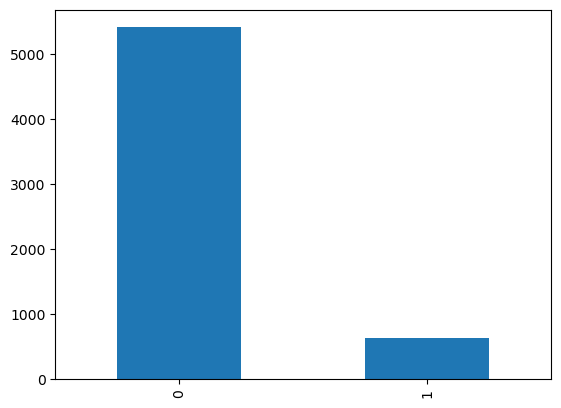

In [ ]:
from matplotlib import pyplot as plt
final_submit['Y_LABEL'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
final_submit['Y_LABEL'].value_counts()

0    5406
1     635
Name: Y_LABEL, dtype: int64